## Debit Spread mappings - quick & dirty version
### debit_spread_qd_v4_1  July 23, 2020.
Copyright 2020, Gary R. Evans<br>
<br>Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:<br><br>
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.<br><br>
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
<br><br>
(MIT License)<br><br>
<b> Programming comments: </b><br>
This is a modification of the credit spread model, which was completed and tested before this was attempted. The model on which this version is based is credit_spread_mappings_qd_v4_4.ipynb
This version only does the mappings. This will do either a put (bear) or call (bull) debit spread. This was tested with NFLX (5 strike-spread), MSFT (2.5 strike spread) and SPY (1 strike-spread) options for both calls and puts.
Designed by Prof Evans for use by students in Econ 136 or students and alumni at Harvey Mudd.<br>
Most recent use date: July 23, 2020

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('c:/Users/Prof Gary Evans/Dropbox/PyGo/PyFi')
import finutil as fu
import timeutil as tu
print (tu.which_timeutil())   # Must be Version 1.5 or above.
print (fu.which_finutil())    # Must be Version 2.9 or above.

Version 1.5 of timeutil.py.
Version 2.9 of finutil.py in PyFi.


This version allows calculation of either puts (bull spreads) or calls (bear spreads).<br>
The short-strike refers to the option that we are writing, which will be more expensive than the hedge.<br>
The hedge refers to the option that we are buying as a hedge. The short_delta will be higher than the hedge_delta, like 0.45 compared to 0.25.

## Data entry goes here

In [3]:
put = False
stosym = "AMD"
exyear = int(2020)
exmonth = int(7)
exday = int (31)
days = 3                  #User must provide days to expiry in q&d
stock_price = 67.72
long_strike = 67.0    #For debit spread, long strike must be closer to the money than the short strike.
long_price = 3.10
short_strike = 69.0
short_price = 2.20

User must enter the strike span (spread between each strike) for the options (1 for SPY, but 5 for NFLX, 10 for others), the number of strikes in the mapping, plus an optional offset.<br> The number or strikes depends upon the spread between strikes. For a mapping that looks right, the user may have to experiment with this.  Try 11 strikes for default for strike span of 5 or 10, more for 1 (like 27 for SPY).<br> We then allow an offset for the sake of appearance. The offset shifts the graph a little to the left or right. If the graph doesn't look centered when drawn, use the offset to shift it and redraw it.

In [4]:
strike_span = float(1.0)  # This would normally be 5 (NFLX), 2.5 (MSFT) or 1 (SPY).
num_strikes = 19  # Must be an odd number. Default 9 for strike_span = 2.5, 11 for strike_span = 5, 27 for 1.
left_offset = 0 # this shifts the center of the mapping left (pos) or right (neg)

## End data entry

These elementary formulas below work for all debit spreads.

In [5]:
spread = short_strike - long_strike
if put:
    spread = spread*(-1.0)
max_gain = spread - (long_price - short_price)
max_loss = short_price - long_price
print ("Spread: {:.2f}, Maximum gain: {:.3f}, and Maximum Loss: {:.3f}.".format(spread,max_gain,max_loss))

Spread: 2.00, Maximum gain: 1.100, and Maximum Loss: -0.900.


Using the data entered above for strike_span, num_strikes, and left_offset, the program calculates the range of the abscissa for the graph.

In [6]:
sides = strike_span*((num_strikes - 1)/2)
center = float(long_strike + (spread/2))
center_adj = center % strike_span
center -= center_adj
if center_adj > (strike_span/2):
    center += strike_span
left_offset = left_offset*strike_span
low_strike = (center - sides + left_offset)
hi_strike = (center + sides + left_offset)
print("The graph will map along the abscissa from {:.1f} to {:.1f}.".format(low_strike,hi_strike))

The graph will map along the abscissa from 59.0 to 77.0.


The range of strikes to be shown on the abscissa is calculated and displayed. Make sure the range of strikes includes the stock price and the strikes of the short and the hedge. This range can be adjusted by the left_offset.

In [7]:
strikes = np.linspace(low_strike, hi_strike, num = num_strikes, dtype = float)
strikes  # This is the range of strikes that will be displayed. Make sure they include the stock, short, and hedge.

array([59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71.,
       72., 73., 74., 75., 76., 77.])

Expiry calculations:

In [8]:
expiry_info = tu.iso_daysto_days(exyear,exmonth,exday)
expiry = expiry_info[0]
days_str = str(days)  # Days to expiry, used in the graph only
expiry_date = tu.date_str_noyr(exmonth, exday)
expiry_date_long = tu.date_str_full(exyear,exmonth,exday)
print("Expiry: {}, {}, days: {:d}.".format(expiry,expiry_date_long,days))

Expiry: 20200731, July 31, 2020, days: 3.


The section below takes the following feature of ALL Credit Spreads into account:
1.  The maximum gain is realized for all strikes below [above] the short strike for a call [put].
2.  The maximum loss is realized for all strikes above [below] the hedge strike for a call [put].
3.  There is a linear connection between max gain and max loss for all strikes in between the short and the hedge. 

Therefore no matter what the credit spread, the payoff mapping can be mapped as three segments! So we start by setting all gains as max loss (put) or max gain (call), which we will later over-ride:

In [9]:
gains = np.ones(num_strikes)
if put:
    gains = gains*max_gain
else:
    gains = gains*max_loss
print(gains)     # Use to debug. This will be an array of identical numbers

[-0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9
 -0.9 -0.9 -0.9 -0.9 -0.9]


We then divide the payoff line into three parts by finding the array element of each of the two strikes. (Note: the np.where command returns a tuple, so we convert that to an integer by taking the first element of the tuple. The result is printed so the user can see what we are doing. If, for example, startit equals 8, that implies that our payoff line will shift starting at the 8th element of the 19-element array).

### Note!: If this below throws an exception, make sure both strikes are included in the "strikes" array (above).
If not, either increase num_strikes above and/or use the left_offset above, then check strikes again.

In [10]:
if put: 
    element1 = np.where(strikes == short_strike)
else:
    element1 = np.where(strikes == long_strike)
startit = int(element1[0])
startit

8

In [11]:
if put:
    element2 = np.where(strikes == long_strike)
else: 
    element2 = np.where(strikes == short_strike)
endit = int(element2[0])
endit

10

Now we adjust the payoff for the middle range between strikes (debugging results printed so the user can see what we are doing):

In [12]:
for i in range(startit+1,endit):
    # print(strikes[i])
    if put:
        gains[i] = gains[i] - (strikes[i] - short_strike)
    else:
        gains[i] = gains[i] + (strikes[i] - long_strike)
print (gains)   #Use to debug. Eliminate when sure.

[-0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9  0.1 -0.9 -0.9 -0.9 -0.9
 -0.9 -0.9 -0.9 -0.9 -0.9]


Finally we set maximum losses (call) or gains (put) for all strikes above the hedge strike:

In [13]:
for i in range(endit,num_strikes):
    # print(strikes[i])
    if put:
        gains[i] = max_loss
    else:
        gains[i] = max_gain
print (gains) #Use to debug. Eliminate when sure.

[-0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9 -0.9  0.1  1.1  1.1  1.1  1.1
  1.1  1.1  1.1  1.1  1.1]


And now we print it:

In [14]:
if put:
    op_type = "Put"
    spread_type = "Bear"
else:
    op_type = "Call"
    spread_type = "Bull"    

For certain mappings it may look better if upper_y and lower_y are changed by 2 rather than 1.

In [15]:
x = strikes
y = gains
upper_x = (x.max())   # formerly int
lower_x = (x.min())   # formerly int
upper_y = (y.max()) + 1   # formerly int
lower_y = (y.min()) - 1   # formerly int

In [16]:
upper_x

77.0

In [17]:
lower_x

59.0

In [18]:
stock_price_str = str(stock_price)
short_strike_str = str(short_strike)
short_price_str = str(short_price)
long_strike_str = str(long_strike)
long_price_str = str(long_price)

Calculate some text and line mapping parameters used in the mapping below:

In [19]:
zero_line = np.zeros(num_strikes)
if put:
    maxga_xloc = 0.5*(strikes[0]+strikes[1])  #Horizontal (x) location of the Max loss text.
    maxga_yloc = math.floor(max_gain*5)/10
    maxlo_xloc = stock_price + (0.5*(strikes[1] - strikes[0]))
    maxlo_yloc = math.floor(max_loss*5)/10
else:
    maxlo_xloc = 0.5*(strikes[0]+strikes[1])  #Horizontal (x) location of the Max loss text.
    maxlo_yloc = math.floor(max_loss*5)/10
    maxga_xloc = short_strike + (0.5*(strikes[1] - strikes[0]))
    maxga_yloc = math.floor(max_gain*5)/10
max_gain_str = str(round(max_gain,2))
max_loss_str = str(round(max_loss,2))

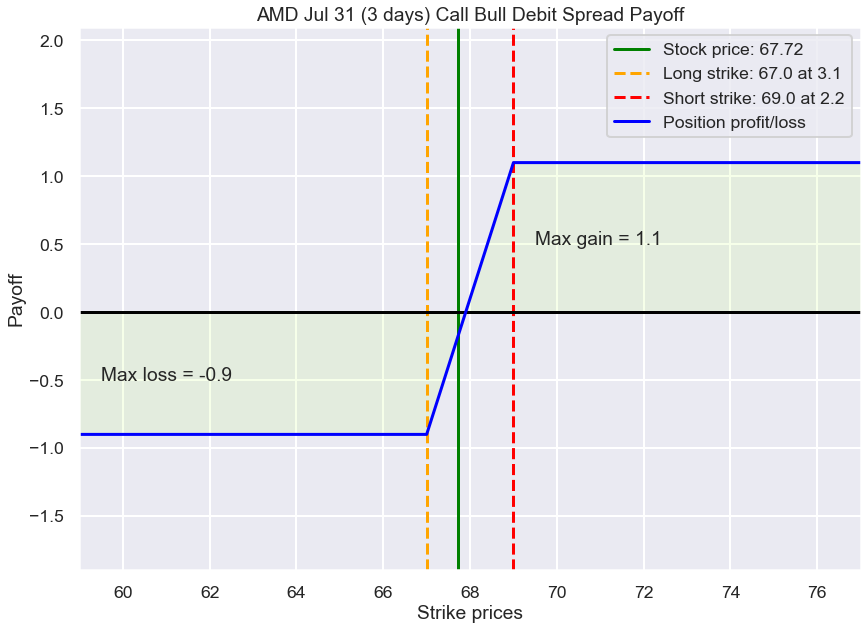

In [20]:
print("")
print("")
fig = plt.figure()
sns.set()
sns.set_style(style="darkgrid")
sns.set_context("poster", font_scale=0.8)
fig.set_size_inches(14,10)
plt.axis([lower_x,upper_x,lower_y,upper_y])
if strike_span == 2.5:
    plt.xticks(np.arange(lower_x,(upper_x + strike_span),strike_span)) # This line can be commented out or in for 
    # appearance. It can be commented out for 1 and 5 strikes, probably should be in for 2.5 strikes or .5 strikes.
# plt.axhline(0, color="black")  #If not using filler, use this.
plt.axvline(stock_price, color="green", label="Stock price: " + stock_price_str)
plt.axvline(long_strike, color="orange", linestyle="--", label="Long strike: " + long_strike_str
    + " at " + long_price_str)
plt.axvline(short_strike, color="red", linestyle="--", label="Short strike: " + short_strike_str 
    + " at " + short_price_str)
plt.plot(x,zero_line, color="black")
plt.plot(x,y, color="blue", label="Position profit/loss")
plt.fill_between(x,zero_line,y,color="greenyellow",alpha=0.10)
plt.title(stosym + " " + expiry_date + " (" + days_str + " days) " + op_type + " " + 
    spread_type + " Debit Spread Payoff")
plt.text(maxlo_xloc,maxlo_yloc,"Max loss = " + max_loss_str)
plt.text(maxga_xloc,maxga_yloc, "Max gain = " + max_gain_str)
plt.ylabel("Payoff")
plt.xlabel("Strike prices")
plt.legend()
plt.show()
print("")
print("")

Print summary results:

In [21]:
print ("Underlying: ", stosym)
print ("Trade is a",op_type,spread_type,"debit spread.")
print ("Stock price: {:.2f}.".format(stock_price))
print ("Expiry: {}.".format(expiry_date_long))
print ("Days: ", days)
print ("Long strike: {:.2f}.".format(long_strike))
print ("Long strike price: {:.2f}.".format(long_price))
print ("Short strike: {:.2f}.".format(short_strike))
print ("Short strike price: {:.2f}.".format(short_price))
print ("Max loss (opening position): {:.2f}.".format(max_loss))
print ("Max gain: {:.2f}.".format(max_gain))

Underlying:  AMD
Trade is a Call Bull debit spread.
Stock price: 67.72.
Expiry: July 31, 2020.
Days:  3
Long strike: 67.00.
Long strike price: 3.10.
Short strike: 69.00.
Short strike price: 2.20.
Max loss (opening position): -0.90.
Max gain: 1.10.


In [22]:
print ("End of program")

End of program
